In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from abides_core import abides
from abides_core.utils import parse_logs_df, ns_date, str_to_ns, fmt_ts
from abides_markets.configs import prmsc1, prmsc2

In [2]:
config = prmsc2.build_config()

In [3]:
config.keys()

dict_keys(['seed', 'start_time', 'stop_time', 'swap_interval', 'agents', 'agent_latency_model', 'default_computation_delay', 'custom_properties', 'random_state_kernel', 'stdout_log_level'])

In [4]:
end_state = abides.run( config )

[5420] INFO abides Simulation Start Time: 2024-11-21 18:19:19.483814
[5420] INFO abides_core.kernel Simulation started at 2022-12-31 23:00:00!
[5420] INFO abides_core.kernel --- Simulation time: 2022-12-31 23:00:00, messages processed: 0, wallclock elapsed: 0.20s ---
[5420] WARNING abides_markets.agents.trading_agent No bid at 2023-01-01 00:00:06
[5420] WARNING abides_markets.agents.trading_agent No ask at 2023-01-01 00:00:06
[5420] INFO abides_core.kernel --- Simulation time: 2023-01-04 01:37:29, messages processed: 100,000, wallclock elapsed: 3.57s ---
[5420] INFO abides_core.kernel --- Simulation time: 2023-01-07 11:21:48, messages processed: 200,000, wallclock elapsed: 7.46s ---
[5420] INFO abides_core.kernel --- Simulation time: 2023-01-10 23:51:03, messages processed: 300,000, wallclock elapsed: 11.57s ---
[5420] INFO abides_core.kernel --- Simulation time: 2023-01-14 10:57:18, messages processed: 400,000, wallclock elapsed: 15.69s ---
[5420] INFO abides_core.kernel --- Simulatio

# All Trading Agent

In [121]:
time_mesh = np.arange(
    config["start_time"],
    config["stop_time"],
    1e9*60*60*24  # Show per 1 day
)
max_time = time_mesh[-1]
trading_agents = end_state["agents"][1:]
num_agent = len(trading_agents)

R2_table = np.zeros((num_agent, len(time_mesh), 2))

for i, agent in enumerate(trading_agents):
    j = 0
    for event in agent.log:
        if event[1] == 'R2':
            if event[0] >= max_time:
                continue
            while event[0] > time_mesh[j]:
                j += 1
            R2_table[i, j] = np.array(event[2])  # R2 of agent i at time j


In [122]:
R2_table = R2_table[:, 1:] # Delete the first blank column

In [123]:
def R2_slice(R2_table, t, plot=False):
    R2_slice = sorted(R2_table[:, t, :], key=lambda x: x[0])
    R2_long = [R2 for R2 in R2_slice if R2[1] > 0]
    R2_short = [R2 for R2 in R2_slice if R2[1] < 0]

    # Here for the summary
    tick_1, tick_2, tick_3, tick_4 = None, None, None, None

    # Long orders
    tick_long = [R2[0] for R2 in R2_long]
    vol_long = [R2[1] for R2 in R2_long]
    tick_long.reverse()
    vol_long.reverse()
    cum_vol_long = np.cumsum(vol_long)

    total_vol_long = cum_vol_long[-1]

    tick_1_done = False 
    for i, cum_vol in enumerate(cum_vol_long):
        if cum_vol > total_vol_long*0.10 and not tick_1_done:
            tick_1 = tick_long[i]
            tick_1_done = True
        if cum_vol > total_vol_long*0.20:
            tick_2= tick_long[i]
            break

    # Short orders
    tick_short = [R2[0] for R2 in R2_short]
    vol_short = [-R2[1] for R2 in R2_short]
    cum_vol_short = np.cumsum(vol_short)

    total_vol_short = cum_vol_short[-1]

    tick_3_done = False 
    for i, cum_vol in enumerate(cum_vol_short):
        if cum_vol > total_vol_short*0.10 and not tick_3_done:
            tick_3 = tick_short[i]
            tick_3_done = True
        if cum_vol > total_vol_short*0.20:
            tick_4 = tick_short[i]
            break

    if plot:
        plt.plot(cum_vol_long, tick_long)
        plt.plot(cum_vol_short, tick_short)

        plt.ylim(0, 3000)
        plt.show()

    return tick_1, tick_2, tick_3, tick_4

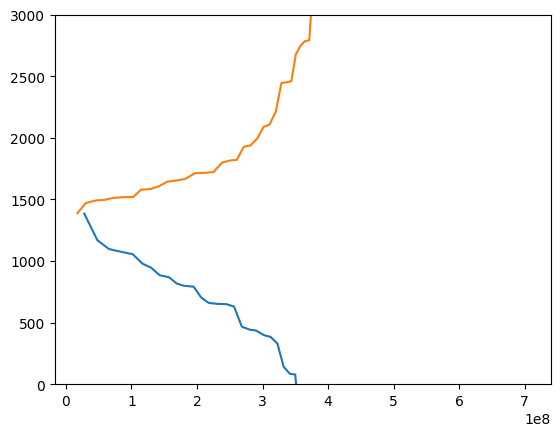

(1075.0, 884.0, 1511.0, 1606.0)

In [140]:
R2_slice(R2_table, 12, plot=True)

In [141]:
R2_summary = np.zeros((R2_table.shape[1], 4))

for i in range(R2_table.shape[1]):
    R2_summary[i, :] = R2_slice(R2_table, i)

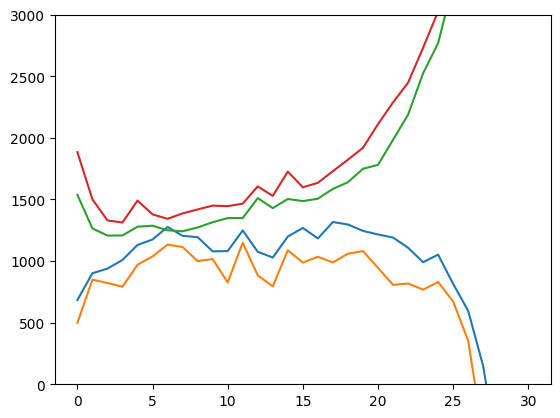

In [143]:
plt.ylim(0, 3000)
plt.plot(R2_summary)
plt.show()

# One value agent

In [127]:
agent = end_state["agents"][1041]

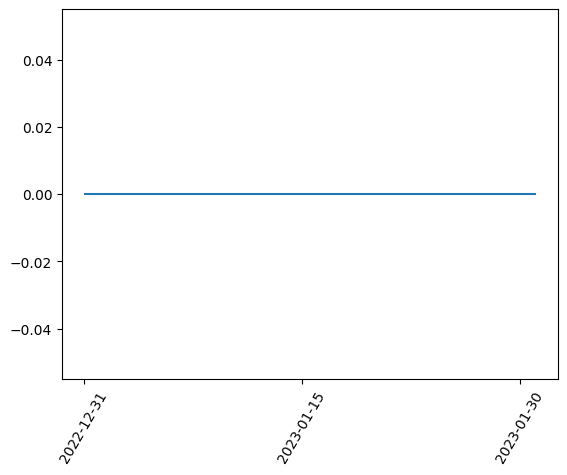

In [128]:
time_index_R1 = []
R1_val = []

for event in agent.log:
    if event[1] == 'R1':
        time_index_R1.append(event[0])
        R1_val.append(event[2])

plt.plot(time_index_R1, R1_val, label="R1")
time_mesh = np.arange(
    config["start_time"],
    config["stop_time"],
    1e9*60*60*24*15  # Show per 5 days
)
_=plt.xticks(time_mesh, [ fmt_ts(time).split(" ")[0] for time in time_mesh], rotation=60 )

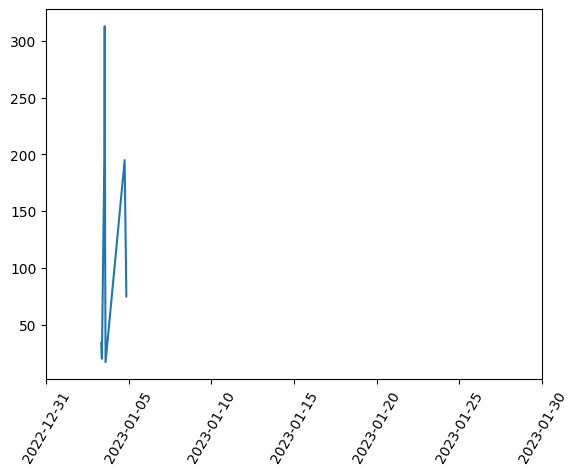

In [129]:
time_index_R2 = []
R2_val = []

for event in agent.log:
    if event[1] == 'R2':
        if event[2][0] > 0 and event[2][0] < 2000:
            time_index_R2.append(event[0])
            R2_val.append(event[2][0])

plt.plot(time_index_R2, R2_val, label="R2")
time_mesh = np.arange(
    config["start_time"],
    config["stop_time"],
    1e9*60*60*24*5  # Show per 5 days
)
_=plt.xticks(time_mesh, [ fmt_ts(time).split(" ")[0] for time in time_mesh], rotation=60 )

# Orderbook

In [130]:
order_book = end_state["agents"][0].order_books["PEN"]

In [131]:
logs_df = parse_logs_df( end_state )

In [132]:
print(logs_df[ (logs_df.agent_type == "LiquidatorAgent")  ].to_string())

                EventTime               EventType                                                                       ScalarEventValue  agent_id       agent_type
1     1970-01-01 00:00:00     STARTING_COLLATERAL                                                                              100000000      1103  LiquidatorAgent
0     1970-01-01 00:00:00              AGENT_TYPE                                                                        LiquidatorAgent      1103  LiquidatorAgent
4     2023-01-01 00:02:06          UNLIQUIDATABLE                                                                                      0      1103  LiquidatorAgent
3     2023-01-01 00:02:06                      R1                                                                                      0      1103  LiquidatorAgent
2     2023-01-01 00:02:06               IMBALANCE                                                                                 [2, 2]      1103  LiquidatorAgent
5     2023-01-01

In [133]:
L1 = order_book.get_L1_snapshots()

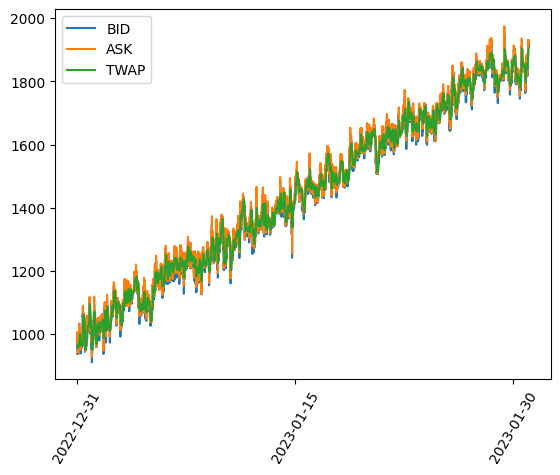

In [134]:
best_bids = pd.DataFrame(L1["best_bids"],columns=["time","price","qty"])
best_asks = pd.DataFrame(L1["best_asks"],columns=["time","price","qty"])
twap = pd.DataFrame(order_book.twap_record,columns=["time","price"])

plt.plot(best_bids.time,best_bids.price, label="BID")
plt.plot(best_asks.time,best_asks.price, label="ASK")
plt.plot(twap.time,twap.price, label="TWAP")
plt.legend()

time_mesh = np.arange(
    config["start_time"],
    config["stop_time"],
    1e9*60*60*24*15  # Show per 15 days
)
_=plt.xticks(time_mesh, [ fmt_ts(time).split(" ")[0] for time in time_mesh], rotation=60 )

In [135]:
transaction_time_mesh = np.arange(
    config["start_time"],
    config["stop_time"] + 1,
    1e9*60*60*24  # Show per 1 day
)
transaction_time_mesh = transaction_time_mesh[1:]  # Drop the first timestamp

In [136]:
buys = pd.DataFrame(order_book.buy_transactions,columns=["time","price","qty"])
sells = pd.DataFrame(order_book.sell_transactions,columns=["time","price","qty"])

buys_pday = np.zeros(len(transaction_time_mesh))
counter = 0
for buy in buys.itertuples():
    if buy.time > transaction_time_mesh[counter]:
        counter += 1
    if counter >= len(transaction_time_mesh):
        break
    buys_pday[counter] += buy.qty

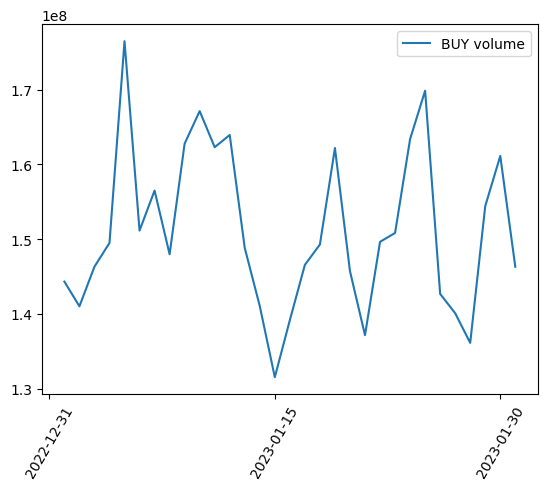

In [144]:
plt.plot(transaction_time_mesh, buys_pday, label="BUY volume")
plt.legend()
plt.xticks(time_mesh, [ fmt_ts(time).split(" ")[0] for time in time_mesh], rotation=60 )
plt.show()